# Esercitazione

In [ ]:
from sklearn.metrics import classification_report

!pip install tensorflow
!pip install tf-models-official
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd

import os
import numpy as np
import itertools


##1. Caricare il dataset

Per questa esercitazione useremo un dataset composto da 50,000 recensioni di film prese dal sito IMDB. L'obiettivo dell'esercitazione è capire quali recensioni esprimono un giudizio favorevole nei confronti del film e quali invece sono recensioni negative, si parla quindi di Sentiment Analysis.
Il dataset proviene da [Kaggle](https://www.kaggle.com/datasets/atulanandjha/imdb-50k-movie-reviews-test-your-bert). Il dataset è diviso in train e test sets, entrambi contenenti 25,000 recensioni. Ogni partizione ha una distribuzione bilanciata tra le classi, 12,500 recensioni positive e 12,500 recensioni negative.

Per poter lavorare è necessario scaricare e decomprimere il dataset, questo possiamo farlo con il comando seguente. 

I dati verranno salvati all'interno della cartella *data/* tra i files della sessione. 
In questa cartella troverete due files csv con lo stesso formato: due colonne, separate da virgola, la prima contiene il testo delle recensioni la seconda il sentiment legato alla recensione, *pos* per recensioni che esprimono un giudizio positivo nei confronti del film, *neg* viceversa.
La seguente tabella mostra un estratto del train set.

|                                                   Text                                                  | Sentiment |
|:-------------------------------------------------------------------------------------------------------:|:---------:|
| My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn't awful e... |    neg    |
| I... No words. No words can describe this. I will try for the sake of those few brave people who sti... |    neg    |
| this film is basically a poor take on the old urban legend of the babysitter who gets crank calls te... |    neg    |
| Cocky medical students play chicken with process that simulates death, in attempt to get a (hopefull... |    pos    |
| This movie is excellent in how it portrays the reality of sexual abuse. The daughters perfectly expr... |    pos    |
| So after years and years I finally track this film down! I was dying to see how it lived up to my me... |    pos    |


In [ ]:
!wget https://www.di.unito.it/~colla/resources/data.zip
!unzip -q data.zip

--2023-05-10 10:26:24--  https://www.di.unito.it/~colla/resources/data.zip
Resolving www.di.unito.it (www.di.unito.it)... 130.192.156.1, 2001:470:1f14:11a1::2
Connecting to www.di.unito.it (www.di.unito.it)|130.192.156.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26505687 (25M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  25.28M  7.66MB/s    in 3.5s    

2023-05-10 10:26:28 (7.19 MB/s) - ‘data.zip.1’ saved [26505687/26505687]

replace data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


Il passo successivo è caricare il dataset, dobbiamo processare i files all'interno della cartella data al fine di caricare in memoria le recensioni con le relative etichette.


funzione che caria il dataset. Data la cartella contenente i files di train e test, la funzione deve caricare i dati e partizionarli in quattro liste da restutire:


*   train_sentences: una lista contenente tutti i testi delle recensioni del training set;
*   train_labels: una lista contenete tutte le etichette associate alle recensioni del train set **NB. la lunghezza della lista deve coincidere con la lunghezza della lista 'train_sentences'**;
*   test_sentences: una lista contenete tutti i testi delle recensioni del test set;
*   , test_labels: una lista contenete tutte le etichette associate alle recensioni del test set **NB. la lunghezza della lista deve coincidere con la lunghezza della lista 'test_sentences'**.



In [ ]:
def load_imdb_data():
  data_path = "./data/"

  # Load train set
  train_df = pd.read_csv(data_path + "train.csv", header=0)
  train_sentences = train_df['text'].tolist()
  train_labels = train_df['sentiment'].tolist()
  train_labels = [0 if x == "neg" else 1 for x in train_labels]

  # Load test set
  test_df = pd.read_csv(data_path + "test.csv", header=0)
  test_sentences = test_df['text'].tolist()
  test_labels = test_df['sentiment'].tolist()
  test_labels = [0 if x == "neg" else 1 for x in test_labels]

  return train_sentences, train_labels, test_sentences, test_labels


Scritta la funzione per processare i files del dataset, possiamo utlizzarla per caricare i nostri train/test sets. Dato che 50,000 recensioni sono molte, potrebbe essere necessario ridurre il numero di esempi caricati per provare il codice o velocizzare il processo.
In questo caso, possiamo usare la variabile *num_examples* per caricare solamente un sottoinsieme dei dati di train/test.

In [ ]:
train_sentences, train_labels, test_sentences, test_labels = load_imdb_data()
# Use 'num_examples' to load a subset of both train/test datasets
num_examples = 1000
train_sentences = train_sentences[:num_examples]
train_labels = train_labels[:num_examples]
test_sentences = test_sentences[:num_examples]
test_labels = test_labels[:num_examples]

print(f'Train Sentences:{ len(train_sentences)}')
print(f'Test Sentences:{ len(test_sentences)}')

Train Sentences:1000
Test Sentences:1000


##2. Costruire il classificatore basato su Glove

Questo comando permette di scaricare e decomprimere i vettori di [GloVe](https://nlp.stanford.edu/projects/glove/). 

I vettori di glove vengono distribuiti in X diverse versioni: glove.6B.50d, glove.6B.100d, glove.6B.200d e glove.6B.300d. 
La differenza fra tutte queste versioni è il numero di dimensioni dei vettori, che sono rispettivamente 50,100,200 e 300 dimensioni.

Il numero di dimensioni è legato alla qualità dell'informazione che vogliamo rappresentare unitamente alla velocità di utilizzo: ad un minor numero di dimensioni corrisponde una minor qualità rappresentazionale ma una maggior velocità di utilizzo, viceversa per vettori con un maggior numero di dimensioni.

Indipendentemente dal numero di dimensioni, i files hanno lo stesso formato: un vettore per ogni riga; ogni riga ha campi separati da uno spazio, il primo campo corrisponde alla parola mentre i seguenti sono tutti i valori del vettore.
Di seguito è riportato un esempio:


```
home -0.092998  0.16297   0.73724  -0.37971   ...
pet   0.51926   0.10875   0.71831   0.019399  ...
```



In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 
!unzip -q glove.6B.zip

--2023-05-10 10:37:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-10 10:37:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-10 10:37:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Una volta completato il download ci occorre una funzione per caricare i vettori in memoria. Per l'esercitazione possiamo utilizzare la versione in cui i vettori hanno 100 dimensioni.


Funzione che carica i vettori di GloVe. Dato il path ad una delle versioni di GloVe, la funzione deve:


*   scorrere tutti i vettori presenti all'interno del file e salvarli all'interno del dizionario *glove_vectors*, in cui le chiavi sono le parole e i valori sono i vettori (attenzione, i vettori devono essere liste di numeri);
*   caricare tutte le parole per cui esiste un vettore di GloVe nella lista *glove_vocabulary*.

la funzione deve restituire il dizionario *glove_vectors* e la lista *glove_vocabulary*.




In [ ]:
# Set the embedding dimensions
embedding_dimensions = 100

In [ ]:
def load_glove():
  path_to_glove_file = "./glove.6B." + str(embedding_dimensions) + "d.txt"

  glove_vectors = {}
  glove_vocabulary = []
  with open(path_to_glove_file) as f:
      for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_vectors[word] = coefs
        glove_vocabulary.append(word)

  return glove_vectors, glove_vocabulary

Per poter addestrare il nostro modello dobbiamo rendere processabili i testi e i giudizi delle nostre recensioni. Dato che le reti non sono in grado di elaborare del testo in formato stringa, ma direttamente nella forma "vettoriale", ci occorre convertire ogni parola in un numero che la identifichi univocamente. Ci serve quindi fare quella che viene chiamata tokenizzazione. 
Ad esempio, data la frase "*the cat sat on the mat*" la tokenizzazione produrrebbe la rappresentazione "*2, 3697, 1686, 15, 2, 5943*".
Data questa tokenizzazione la rete è adesso in grado di associare ad ogni parola la forma a vettoriale contenuta nell'embedding layer, ed utilizzarla durante l'elaborazione.

In [ ]:
# Load glove vectors together with glove vocabulary
glove_vectors, glove_vocabulary = load_glove()

# Fit the vectorizer to GloVe vocabulary
vectorizer = tf.keras.layers.TextVectorization(output_sequence_length=128)
vectorizer.adapt(glove_vocabulary)

# Get vectorizer's vocabulary
voc = vectorizer.get_vocabulary()

word_index = dict(zip(voc, range(len(voc))))


In [ ]:
print(vectorizer("My favourite framework is Tensorflow. I love coding"))
print(word_index["[UNK]"])

tf.Tensor(
[  7154 258322 251451   2927      1   8103   7607 298524      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0], shape=(128,), dtype=int64)
1


La funzione seguente permette di costruire il modello basato sui vettori di GloVe.
Il processo è il seguente:


1. carica i vettori ed il vocabolario di GloVe con la funzione appena scritta;
2.   costruisce un tokenizer sul vocabolario di GloVe, cioè assegna un identificatore numerico ad ogni parola del vocabolario di GloVe;
3.   costruisce la matrice di embedding, da identifcatore numerico a vettore;
4.   costruisce il modello con un livello di embedding, una BLSTM e un livello finale che ci serve per la predizione.



In [ ]:
def build_glove_model():
  
  # Load glove vectors together with glove vocabulary
  glove_vectors, glove_vocabulary = load_glove()

  # Fit the vectorizer to GloVe vocabulary
  vectorizer = tf.keras.layers.TextVectorization(output_sequence_length=128)
  vectorizer.adapt(glove_vocabulary)
  
  # Get vectorizer's vocabulary
  voc = vectorizer.get_vocabulary()

  word_index = dict(zip(voc, range(len(voc))))
  num_tokens = len(voc) + 2

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dimensions))
  for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector

  # Build the model
  # Build the embedding layer
  embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dimensions,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True,
  )
  # Set the input layer
  int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
  # Apply the embedding layer on the input layer
  embedded_sequences = embedding_layer(int_sequences_input)
  # Apply a dropout to avoid overfitting
  x = tf.keras.layers.Dropout(0.1)(embedded_sequences)
  # Set up the BLSTM layer
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
  # Last layer for predictions
  preds = tf.keras.layers.Dense(1, activation=None)(x)
  model = tf.keras.Model(int_sequences_input, preds)
  return model, vectorizer, word_index


Il seguente codice carica il modello usando la funzione appena definita e ne mostra una rappresentazione grafica. 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         37503900  
                                                                 
 dropout_6 (Dropout)         (None, None, 100)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 37,738,653
Trainable params: 37,738,653
Non-trainable params: 0
_______________________________________________

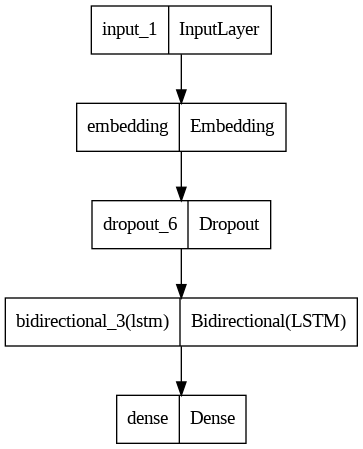

In [ ]:
# Load the model
glove_model, glove_tokenizer, word_index = build_glove_model()
# Print model summary
glove_model.summary()
# Plot a figure representing the model
tf.keras.utils.plot_model(glove_model)

###2.1. Addestrare/Testare il modello basato su GloVe

Una volta costruito il modello possiamo passare alla fasi di addestramento (sul train set) e valutazione (sul test set). 


Funzione che faccia la tokenizzazione di tutte le recensioni contenute nella lista *sentences_list* ricevuta come parametro. La funzione deve restituire una lista contenente le recensioni tokenizzate nello stesso ordine in cui sono state ricevute.

In [ ]:
def tokenize_data(sentences_list, tokenizer):
  return [tokenizer(x) for x in sentences_list]

Una volta pre-processati i dati possiamo avviare il training del nostro modello. La funzione di seguito definisce i parametri principali dell'addestramento, cioè che tipo di Loss Function usare, il numero di epoche per cui addestrare il modello, il tipo di ottimizzatore da utilizzare e la metrica da considerare durante l'apprendimento.
L'istruzione finale *model.fit* permette di avviare l'addestramento del modello appena creato sul *training_dataset*.

In [ ]:
def train_glove_model(model, tokenizer, train_sentences):
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()

  # Create train dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(tokenize_data(train_sentences, tokenizer), dtype=tf.int64), tf.convert_to_tensor(train_labels, dtype=tf.int32)))
  train_dataset = train_dataset.batch(128)
  train_dataset = train_dataset.shuffle(len(train_labels), reshuffle_each_iteration=True)

  # Setup training parameters
  epochs = 5
  steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  # Build Optimizer
  init_lr = 3e-5
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

  # Create the model
  model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = model.fit(x=train_dataset, epochs=epochs)

Infine ci serve creare una funzione che permetta di valutare il modello allenato con la funzione precedente sul test set. 
La funzione seguente, dopo aver pre-processato (tokenizzato) il dataset di test, utilizza il modello ricevuto come parametro per predire le classi sulle recensioni del test set.

In [ ]:
def test_glove_model(model, tokenizer, test_sentences):
  # Evalautate
  test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(tokenize_data(test_sentences, tokenizer), dtype=tf.int64), tf.convert_to_tensor(test_labels, dtype=tf.int32)))
  test_dataset = test_dataset.batch(128)
  loss, accuracy = model.evaluate(test_dataset)
  print(f'Loss: {loss}')
  print(f'Accuracy: {accuracy}')

  predictions = model.predict(test_dataset)
  predictions = [0 if x < 0.5 else 1 for x in predictions]
  print(classification_report(test_labels, predictions))

Una volta definite le due funzioni precedenti possiamo utilizzarle per addestrare e valutare il modello che abbiamo costruito.

In [ ]:
train_glove_model(glove_model, glove_tokenizer, train_sentences)

test_glove_model(glove_model, glove_tokenizer, test_sentences)

Epoch 1/5
8/8 [==============================] - 4s 53ms/step - loss: 0.6965 - binary_accuracy: 0.5130
Epoch 2/5
8/8 [==============================] - 0s 44ms/step - loss: 0.6959 - binary_accuracy: 0.5130
Epoch 3/5
8/8 [==============================] - 0s 44ms/step - loss: 0.6938 - binary_accuracy: 0.5130
Epoch 4/5
8/8 [==============================] - 0s 44ms/step - loss: 0.6940 - binary_accuracy: 0.5130
Epoch 5/5
8/8 [==============================] - 1s 15ms/step - loss: 0.6930 - binary_accuracy: 0.5150
Loss: 0.6929799914360046
Accuracy: 0.5149999856948853
8/8 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       515
           1       0.00      0.00      0.00       485

    accuracy                           0.52      1000
   macro avg       0.26      0.50      0.34      1000
weighted avg       0.27      0.52      0.35      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##3. Costruire il classificatore basato su Transformers

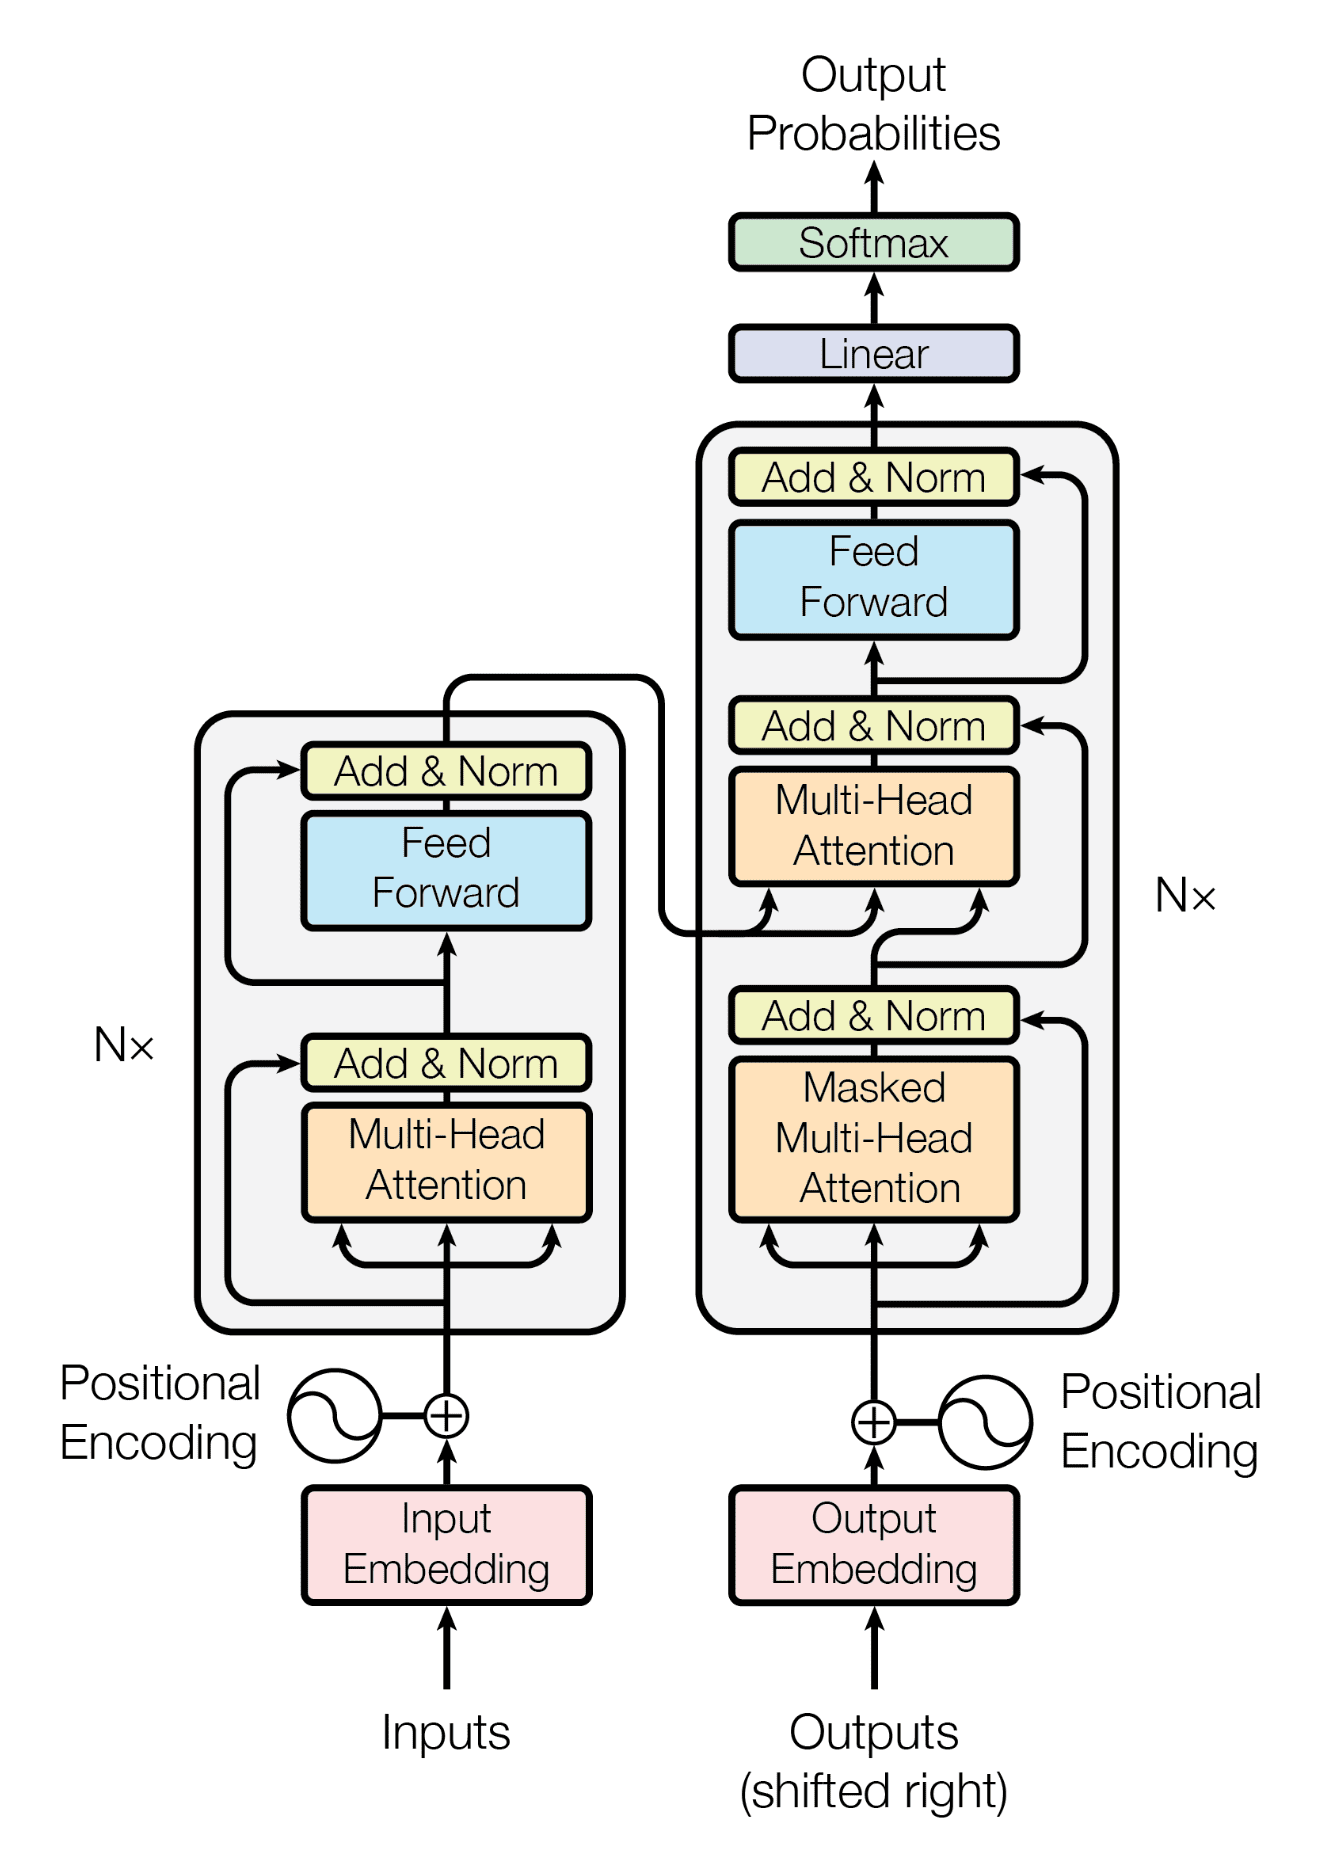

L'architettura a transformers è un'architettura neurale allenata su una grande quantità di testi, in grado di produrre embeddings, associati ai tokens costitutivi della frase in input, con la particolarità di essere *contestuali*. Contestuali significa diversi a seconda della frase, e quindi agli altri token della frase, in cui quel dato token occorre.
È evidente quindi come l'informazione contenuta in questi embeddings sia più fine e ricca rispetto a quella che può essere contenuta in mebeddings statici, capace di cogliere sfaccetture diverse di una stessa parola in rappresentazioni differenti, rispetto alla singola rapprsentazione "media" fornita dagli embeddings statici.

Diversamente da Glove, non è necessario in questo caso caricare un set di embeddings, ma un language model pre-allenato. Anche in questo caso è necessaria una fase di tokenizzazione che converte il testo in token indicizzati. Ci sono però alcune differenze rispoetto la tokenizzatore utilizzato in glove.


1.   La frase viene in questo caso elaborata e inserita tra due speciali tag che indicano l'inizio ([CLS]) e la fine ([SEP]) della frase.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoded_input = tokenizer(["the cat is on the mat"], return_tensors='tf')
print(encoded_input["input_ids"])
print(tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0]))
#print(tokenizer.decode(encoded_input["input_ids"][0]))

tf.Tensor([[  101 10105 41163 10124 10135 10105 17255   102]], shape=(1, 8), dtype=int32)
['[CLS]', 'the', 'cat', 'is', 'on', 'the', 'mat', '[SEP]']


  2. A differenza di glove, il tokenizzatore dei transformers non si troverà mai di fronte ad una parola out of vocabulary. Infatti il vocabolario, in questo caso, è costruito usando sotto-token, ovvero sottocomponenti delle parole, che possono essere composti tra di loro per formare una parola non direttamente presnte in vocabolario. 
  Come possiamo vedere, nel primo esempio proposto, ogni parola viene indicizzata correttamente e nessuna parola viene scomposta. Nel secondo invece (nel blocco di codice successivo), la parola Tensorflow non è contenuta direttamente nel vocabolario, ma al posto di essere indicizzata come OOV viene scomposta e indicizzata attraverso i sottotoken  che la scompongono.
  

In [ ]:
encoded_input = tokenizer(["My favourite framework is Tensorflow. I love coding"], return_tensors='tf')
print(encoded_input["input_ids"])
print(tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0]))

tf.Tensor(
[[   101  11590  80494  54387  10124  16411  28919 105739    119    146
   16138  86604  10376    102]], shape=(1, 14), dtype=int32)
['[CLS]', 'My', 'favourite', 'framework', 'is', 'Ten', '##sor', '##flow', '.', 'I', 'love', 'codi', '##ng', '[SEP]']


In [ ]:
encoded_input = tokenizer(["My daughter liked it but I was aghast, that a character in this movie smokes."], return_tensors='tf')
print(encoded_input["input_ids"])
print(tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0]))

tf.Tensor(
[[   101  11590  15243  11850  10162  10271  10473    146  10134  16942
   20578  10123    117  10189    169  15092  10106  10531  18379 100332
   10107    119    102]], shape=(1, 23), dtype=int32)
['[CLS]', 'My', 'daughter', 'like', '##d', 'it', 'but', 'I', 'was', 'ag', '##has', '##t', ',', 'that', 'a', 'character', 'in', 'this', 'movie', 'smoke', '##s', '.', '[SEP]']


In [ ]:
encoded_input

{'input_ids': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[   101,  11590,  15243,  11850,  10162,  10271,  10473,    146,
         10134,  16942,  20578,  10123,    117,  10189,    169,  15092,
         10106,  10531,  18379, 100332,  10107,    119,    102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]], dtype=int32)>}

Anche la conversione in embeddings cambia rispetto al modello costruito con Glove. Bert infatti si presenta come modello compatto che prende in input l'output codificato del tokenizzatore e produce due tipi di output:  

1.   il primo è una rappresentazione in forma embedding di ogni parola all'interno della frase;
2.   il secondo è un unico embedding, quello del tag iniziale, il [CLS], che dopo vari studi è emerso possa essere considerato un cosiddetto "sentence embedding", che raccoglie dentro di sè una rappresentazione condensata della frase di cui funge da start token.

Per comodità, il modello bert restituisce questi output separatamente.



In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'
text_input = ["My favourite framework is Tensorflow. I love coding"]
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{outputs["pooled_output"].shape}')
print(f'Pooled Outputs Values:{outputs["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{outputs["sequence_output"].shape}')
print(f'Sequence Outputs Values:{outputs["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.32325873 -0.20068018  0.38755903 -0.2167016  -0.04561144  0.45701122
  0.31035775  0.42998514 -0.5296009   0.37414888 -0.06483027 -0.26475585]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.42766553 -0.14020334 -0.17767414 ...  0.604911   -0.17562835
  -0.09929426]
 [ 0.58179927 -0.5178926   0.12819509 ...  0.21629047 -0.46066755
  -0.32879853]
 [ 0.3448778  -0.62018025 -0.21239841 ...  0.15637065 -0.01157895
  -0.29385826]
 ...
 [ 0.3172306  -0.39053503  0.24403122 ...  0.6220595  -1.0896094
  -0.18149586]
 [ 0.7810285  -0.4594262  -0.24843779 ...  0.7919218  -0.81810147
   0.10072853]
 [ 0.48542172 -0.24725743 -1.0798802  ... -0.17603132 -0.4668165
  -0.8211762 ]]


###3.1. Costruire il classificatore basato su vettori dei token

In [ ]:
def build_classifier_model_token_vectors():
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
  tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['sequence_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, name='reduction'))(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

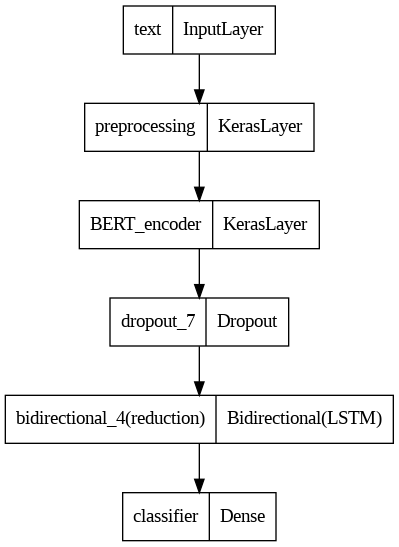

In [ ]:
classifier_model_token = build_classifier_model_token_vectors()
# Plot the model
tf.keras.utils.plot_model(classifier_model_token)

###3.2. Costruire il classificatore basato su vettori delle frasi

In [ ]:
def build_classifier_model_sentence_vector():
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
  tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


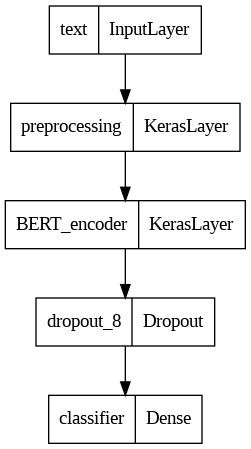

In [ ]:
classifier_model_sentence = build_classifier_model_sentence_vector()
# Plot the model
tf.keras.utils.plot_model(classifier_model_sentence)

###3.3 Addestrare/Testare il modello basato su Transformers

In [ ]:
def train_model(model, train_sentences):
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()

  # Create train dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_sentences, dtype=tf.string), tf.convert_to_tensor(train_labels, dtype=tf.int32)))
  train_dataset = train_dataset.batch(8)
  train_dataset = train_dataset.shuffle(len(train_labels), reshuffle_each_iteration=True)

  # Setup training parameters
  epochs = 5
  steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  # Build Optimizer
  init_lr = 3e-5
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

  # Create the model
  model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = model.fit(x=train_dataset, epochs=epochs)

In [ ]:
def test_model(model, test_sentences):
  # Evalautate
  test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_sentences, dtype=tf.string), tf.convert_to_tensor(test_labels, dtype=tf.int32)))
  test_dataset = test_dataset.batch(8)
  loss, accuracy = model.evaluate(test_dataset)
  print(f'Loss: {loss}')
  print(f'Accuracy: {accuracy}')

  from sklearn.metrics import classification_report
  predictions = model.predict(test_dataset)
  predictions = [0 if x < 0.5 else 1 for x in predictions]
  print(classification_report(test_labels, predictions))

Addestriamo il modello costruito con i vettori di ogni parola sulle recensioni del training set e valutiamo il modello allenato sul test set.

In [ ]:
# Train the model on token-level task
train_model(classifier_model_token, train_sentences)

# Test the model on token-level task
test_model(classifier_model_token, test_sentences)

Epoch 1/5
125/125 [==============================] - 67s 351ms/step - loss: 0.6837 - binary_accuracy: 0.5550
Epoch 2/5
125/125 [==============================] - 43s 341ms/step - loss: 0.4597 - binary_accuracy: 0.7860
Epoch 3/5
125/125 [==============================] - 43s 344ms/step - loss: 0.2544 - binary_accuracy: 0.9160
Epoch 4/5
125/125 [==============================] - 43s 342ms/step - loss: 0.1142 - binary_accuracy: 0.9690
Epoch 5/5
125/125 [==============================] - 14s 93ms/step - loss: 1.1596 - binary_accuracy: 0.7960
Loss: 1.1595827341079712
Accuracy: 0.7960000038146973
125/125 [==============================] - 13s 95ms/step
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       515
           1       0.82      0.74      0.78       485

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



Addestriamo il modello costruito con i vettori di ogni recensione sul training set e valutiamo il modello allenato sul test set.

In [ ]:
# Train the model on token-level task
train_model(classifier_model_sentence, train_sentences)

# Test the model on token-level task
test_model(classifier_model_sentence, test_sentences)

Epoch 1/5
125/125 [==============================] - 62s 333ms/step - loss: 0.7352 - binary_accuracy: 0.4980
Epoch 2/5
125/125 [==============================] - 41s 328ms/step - loss: 0.6191 - binary_accuracy: 0.6360
Epoch 3/5
125/125 [==============================] - 41s 327ms/step - loss: 0.4467 - binary_accuracy: 0.8250
Epoch 4/5
125/125 [==============================] - 41s 328ms/step - loss: 0.2817 - binary_accuracy: 0.9120
Epoch 5/5
125/125 [==============================] - 12s 90ms/step - loss: 0.8729 - binary_accuracy: 0.8090
Loss: 0.872871458530426
Accuracy: 0.8090000152587891
125/125 [==============================] - 12s 90ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       515
           1       0.81      0.79      0.80       485

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



In [ ]:
test_model(classifier_model_sentence, test_sentences)

125/125 [==============================] - 12s 94ms/step - loss: 0.8729 - binary_accuracy: 0.8090
Loss: 0.872871458530426
Accuracy: 0.8090000152587891
125/125 [==============================] - 11s 85ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       515
           1       0.81      0.79      0.80       485

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

